In [1]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
from skeleton import Skeleton
from coco import Coco
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image
import torch

%matplotlib inline

In [2]:
image_index = 6


In [3]:
coco = Coco().load_annotations()

In [4]:
label = coco.get_metadata(image_index)

skeleton = Skeleton(
    img_shape=label['shape'],
    skeleton=label['skeleton'],
    keypoints=label['keypoints'],
    bbox=label['bbox']
)

### Confidence map

In [5]:
print(label)

{'skeleton': [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12], [7, 13], [6, 7], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3], [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7]], 'keypoints': [(0, 0, 0), (0, 0, 0), (0, 0, 0), (357, 42, 2), (391, 56, 2), (310, 72, 2), (378, 79, 2), (0, 0, 0), (414, 147, 2), (0, 0, 0), (448, 190, 2), (271, 193, 2), (323, 202, 2), (332, 270, 1), (380, 285, 2), (311, 373, 1), (390, 414, 2)], 'bbox': [257.72, 7.16, 219.06, 443.49], 'path': '/home/brage/Desktop/paper-zoo/cv/openpose/train2017/000000143908.jpg', 'shape': (480, 640)}


In [6]:
@widgets.interact(min=-10, max=30)
def f(
        sigma=widgets.FloatSlider(min=0, max=10, step=1, value=5), 
        keypoint=widgets.IntSlider(min=0, max=16, step=1, value=4), 
    ):
    _, axarr = plt.subplots(1, 2, figsize=(15,10))

    results = skeleton.confidence_map()[keypoint]
    heatmap = results.reshape((1, ) + label['shape'])
    heatmap = torch.concat(
        [
            heatmap,
            heatmap,
            heatmap
        ]
    )
    image = transforms.ToTensor()(Image.open(label['path']))

    img, h_img = TF.to_pil_image(image), TF.to_pil_image(heatmap)
    res = Image.blend(img, h_img, 0.7)

    skeleton.sigma = sigma
    axarr[0].imshow(results)
    axarr[1].imshow(res)

interactive(children=(FloatSlider(value=5.0, description='sigma', max=10.0, step=1.0), IntSlider(value=4, desc…

## Paf

In [7]:
@widgets.interact(min=-10, max=30)
def f(
        sigma=widgets.FloatSlider(min=0, max=1000, step=1, value=5), 
        limb=widgets.IntSlider(min=0, max=17, step=1, value=4), 
    ):
    skeleton.sigma = sigma
    results = skeleton.paf_field()
    heatmap = ((results[limb] != 0) * 1)[:, :, 0].float().reshape((1, ) + label['shape'])
    heatmap = torch.concat(
        [
            heatmap,
            heatmap,
            heatmap
        ],
        dim=0,
    )

    _, axarr = plt.subplots(1, 2, figsize=(15,10))
    image = transforms.ToTensor()(Image.open(label['path']))

    img, h_img = TF.to_pil_image(image), TF.to_pil_image(heatmap)
    res = Image.blend(img, h_img, 0.7)

    axarr[0].imshow(h_img)
    axarr[1].imshow(res)

interactive(children=(FloatSlider(value=5.0, description='sigma', max=1000.0, step=1.0), IntSlider(value=4, de…

## Segmentation model

[257.72, 7.16, 219.06, 443.49]


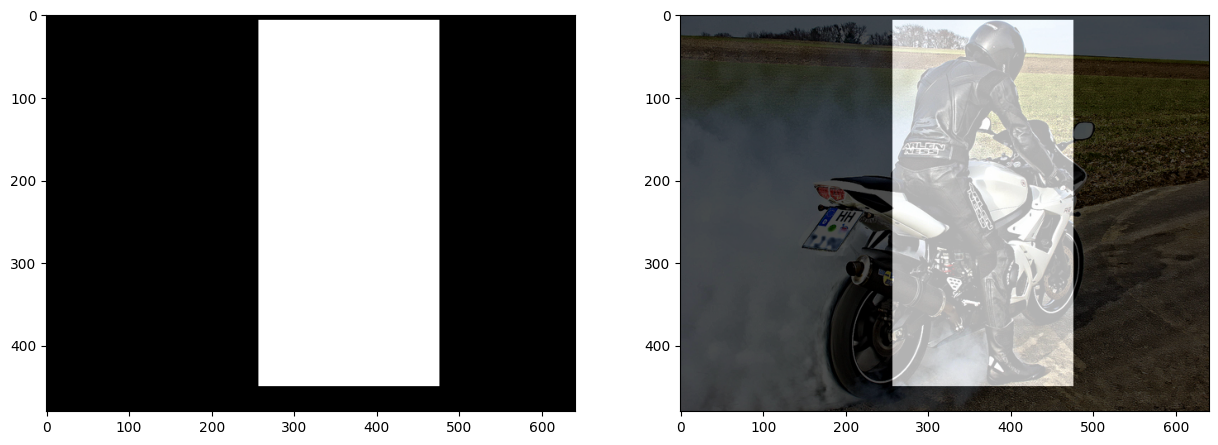

In [8]:
print(coco.results[6].bbox)
heatmap = skeleton.annotation_map(channels=3)

_, axarr = plt.subplots(1, 2, figsize=(15,10))
image = transforms.ToTensor()(Image.open(label['path']))

img, h_img = TF.to_pil_image(image), TF.to_pil_image(heatmap)
res = Image.blend(img, h_img, 0.7)

axarr[0].imshow(h_img)
axarr[1].imshow(res)

### Merge 

index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0


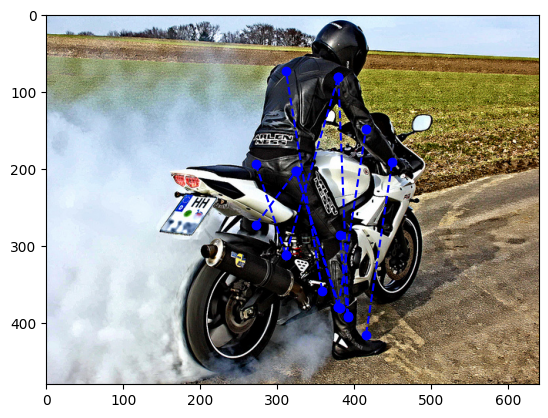

In [9]:
# Probably because of the sloppy merge logic
items = list(skeleton.merge(
    skeleton.confidence_map(),
    skeleton.paf_field()
))
coco.results[image_index].plot_image_skeleton_keypoints(items)